In [178]:
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

In [179]:
C_ELEGANS_TAXID = 6239

df = pd.read_csv("synergyage_database.csv").iloc[:, :-1].copy()
df.head(3)

,Pubmed ID,Temperature,Diet,Details,Wild type lifespan (days),Gene 1,Intervention on gene 1,Gene 1 single mutant lifespan (days),"Gene(s) 2(,3)","Intervention(s) on gene 2(,3)","Gene(s) 2(,3) mutant lifespan (days)","Double (triple) mutant (genes 1,2,(3)) lifespan (days)",Phenotype description,Organism
0,19461873,25,OP50,�Late L4 larvae growing at 20�C were transferr...,13.6,hif-1,RNAi,16.1,daf-16,mgDf47,10.5,12.4,Lifespan extension by�hif-1�did not require DA...,6239
1,19461873,25,OP50,�Late L4 larvae growing at 20�C were transferr...,13.6,hif-1,RNAi,16.1,daf-2,e1370,29.0,35.0,hif-1�RNAi further extended the lifespan of a�...,6239
2,19461873,25,OP50,�Late L4 larvae growing at 20�C were transferr...,13.6,hif-1,RNAi,16.1,unc-24;daf-15,e138;m634,16.6,16.6,Inhibition of�hif-1�by RNAi did not further ex...,6239


In [180]:
df_celegans = df.loc[df['Organism'] == C_ELEGANS_TAXID]
df_celegans.shape

(3391, 14)

In [181]:
def clean_spaces_list_str(alist) -> list:
    """Remove white space, check if `,` and further split."""
    alist_augmented = []
    for elem in alist:
        if "," in elem:
            alist_augmented += elem.split(",")
        else:
            alist_augmented.append(elem)
        
    alist_cleaned = []
    for elem in alist_augmented:
        if elem[0] == " ":
            alist_cleaned.append(elem[1:])
        elif elem[-1] == " ":
            alist_cleaned.append(elem[:-1])
        else:
            alist_cleaned.append(elem)
    return alist_cleaned


INTERVENTION_GENES_1_COL = "Gene 1"
INTERVENTION_GENES_2_COL = "Gene(s) 2(,3)"

intervention_genes = []
intervention_genes_str = []
for i, row in df_celegans.iterrows():
    genes_1 = row[INTERVENTION_GENES_1_COL].split(";")
    genes_1 = clean_spaces_list_str(genes_1)
            
    genes_2 = row[INTERVENTION_GENES_2_COL].split(";")
    genes_2 = clean_spaces_list_str(genes_2)
    
    sorted_l = sorted([*genes_1, *genes_2])
    intervention_genes.append(tuple(sorted_l))
    intervention_genes_str.append(";".join(sorted_l))

df_celegans.loc[:, "genes"] = intervention_genes
df_celegans.loc[:, "genes_str"] = intervention_genes_str
df_celegans.loc[:, "num_genes"] = list(map(len, intervention_genes))

/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:title={'center':'Number of genes intervened upon.'}, ylabel='Frequency'>

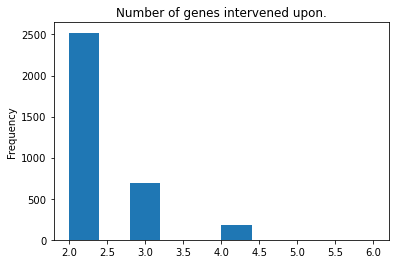

In [182]:
df_celegans["num_genes"].plot.hist(title="Number of genes intervened upon.")

In [183]:
genes = reduce(lambda s1, s2: s1.union(s2), intervention_genes, set([]))

<AxesSubplot:title={'center':'log2( # replicated combinations )'}, ylabel='Frequency'>

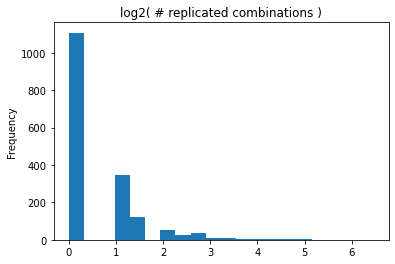

In [184]:
# need remove duplicated interventions
df_celegans["genes"].value_counts().transform(np.log2).plot.hist(title="log2( # replicated combinations )", bins=20)
# plt.plot(df_celegans["genes"].value_counts().values)

In [192]:
BASELINE_LS_COL = "Wild type lifespan (days)"
EFFECT_LS_COL = "Double (triple) mutant (genes 1,2,(3)) lifespan (days)"

df_celegans.loc[df_celegans[BASELINE_LS_COL].isna(), BASELINE_LS_COL] = df_celegans[BASELINE_LS_COL].dropna().mean()
assert df_celegans[BASELINE_LS_COL].isna().sum() == 0 and df_celegans[EFFECT_LS_COL].isna().sum() == 0
df_celegans.loc[:, "FC"] = df_celegans[EFFECT_LS_COL] / df_celegans[BASELINE_LS_COL]
df_celegans.loc[:, "LOGFC"] = np.log2(df_celegans["FC"])
df_celegans.loc[:, "PERCENT_CHANGE"] = (df_celegans[EFFECT_LS_COL] - df_celegans[BASELINE_LS_COL]) / df_celegans[BASELINE_LS_COL]

/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:title={'center':'log2(FC) distribution across all combinatorial interventions'}, ylabel='Frequency'>

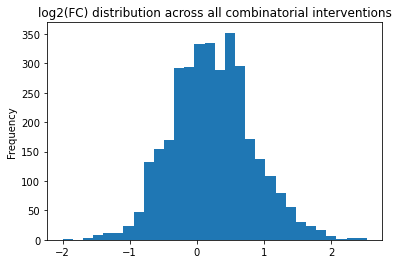

In [186]:
df_celegans["LOGFC"].plot.hist(title="log2(FC) distribution across all combinatorial interventions", bins=30)

In [193]:
(abs(df_celegans["LOGFC"]) > 0.5).sum()

1494

In [194]:
LOGFC_CUTOFF = 0.5

conditions = [
    ( abs(df_celegans["LOGFC"]) <= 0.2 ),
    ( df_celegans["LOGFC"] > 0.2 ),
    ( df_celegans["LOGFC"] < -0.2 ),
]
values = INTERVENTION_CLASSES

df_celegans["LIFESPAN_CLASS"] = np.select(conditions, values)

/tmp/ipykernel_1000137/231847426.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_celegans["LIFESPAN_CLASS"] = np.select(conditions, values)


In [195]:
df_celegans.to_csv("synergyage_database_augmented.tsv", sep="\t")